---
title: "Joint Inversion Using Cross-Gradient Regularization"
authors:
  - id: jcapriotti
---

```{admonition} Advanced notebook
:class: danger
This tutorial focusses on advanced functionality within SimPEG. Basic and intermediate level functionality are not discussed in detail, as we assume the user is already an experienced SimPEG user.
```

```{admonition} Medium-weight notebook
:class: caution
Requires moderate computational resources. Run-times may exceed several minutes and require up to 8 GB of available RAM.
```

**Keywords:** joint inversion, cross-gradient.

</br>

**Summary:** Here, we consider two geophysical datasets whose diagnostic physical properties are different (e.g. gravity and magnetic data). If collected over the same region, we expect independent inversion of these datasets to recover models containing similar structures. Here, we demonstrate joint inversion using the [CrossGradient](xref:simpeg#simpeg.regularization.CrossGradient) regularization class. Cross-gradient enforces similar structures in the recovered models for different physical properties. For this tutorial, we jointly invert gravity and magnetic data to recover density contrast and magnetic susceptibility models. However, this approach can be applied to any other combination of geophysical datasets.

</br>

**Learning Objectives:**

- Considering mesh design for multiple datasets.
- How to define the data misfit and regularization for multiple datasets and physical property types.
- How to implement inversion directives for joint inversion.

## Import Modules

Here, we import all of the functionality required to run the notebook for the tutorial exercise.

In [1]:
# SimPEG Functionality
from simpeg.utils import plot2Ddata
from simpeg.potential_fields import gravity, magnetics
from simpeg import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)

# Discretize functionality
from discretize import TensorMesh
from discretize.utils import active_from_xyz

# Other Python functionality
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tarfile

mpl.rcParams.update({"font.size": 14})

## Load Tutorial Files

Here, we download and import the data, topography, and other resources into the SimPEG framework. For this tutorial, we have gravity anomaly and total magnetic intensity data that were generated for synthetic density and magnetic susceptibility models, respectively. These files are stored within a Google Cloud bucket. 

In [2]:
# storage bucket where we have the data
data_source = (
    "https://storage.googleapis.com/simpeg/doc-assets/cross_gradient_data.tar.gz"
)

# download the data
downloaded_data = utils.download(data_source, overwrite=True)

# unzip the tarfile
tar = tarfile.open(downloaded_data, "r")
tar.extractall()
tar.close()

# path to the directory containing our data
dir_path = downloaded_data.split(".")[0] + os.path.sep

# files to work with
topo_filename = dir_path + "topo.txt"
model_filename = dir_path + "true_model.txt"

overwriting D:\Documents\Repositories\user-tutorials\notebooks\11-joint-inversion\cross_gradient_data.tar.gz
   saved to: D:\Documents\Repositories\user-tutorials\notebooks\11-joint-inversion\cross_gradient_data.tar.gz
Download completed!


In [3]:
# Load topography
xyz_topo = np.loadtxt(topo_filename)

# Load field data
xyz_grav = np.loadtxt(dir_path + "gravity_data.obs")
xyz_mag = np.loadtxt(dir_path + "magnetic_data.obs")

Parse into receiver locations and observed data. For this tutorial, the gravity and magnetic data were simulated at the same locations.

In [4]:
receiver_locations = xyz_grav[:, 0:3]
dobs_grav = xyz_grav[:, -1]
dobs_mag = xyz_mag[:, -1]

## Plot the Observed Data

Here, we plot the observed data and topography.

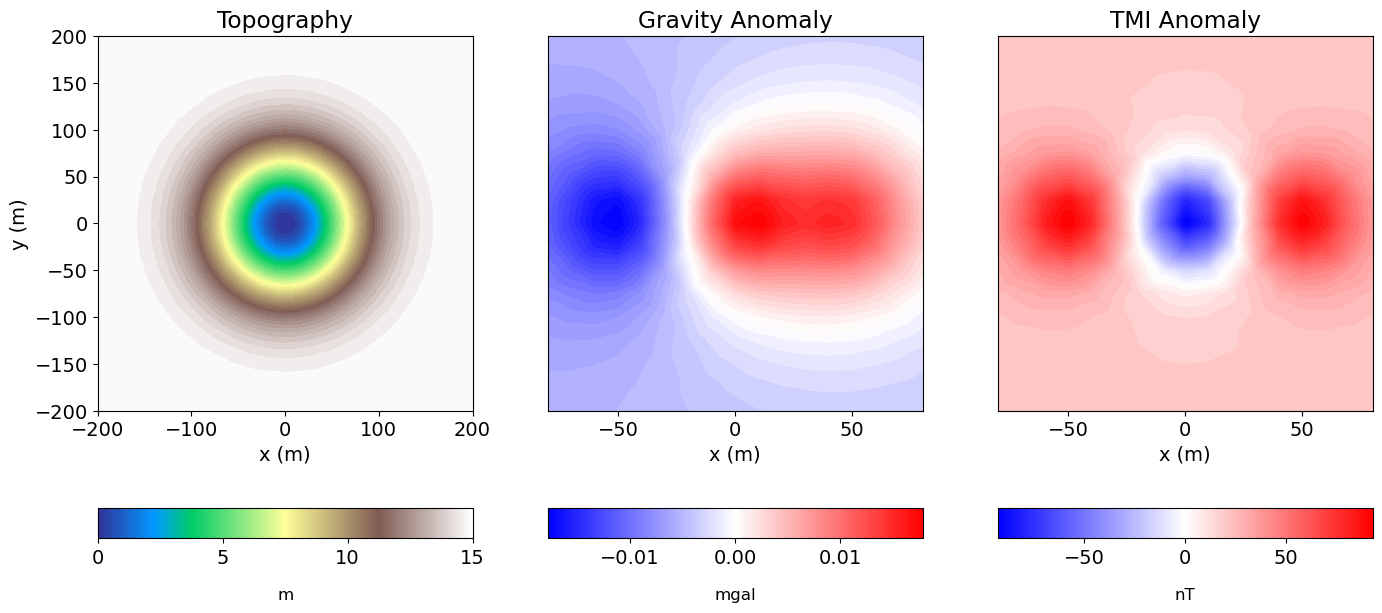

In [5]:
fig = plt.figure(figsize=(15, 6))

data_list = [xyz_topo, xyz_grav, xyz_mag]
title_list = ["Topography", "Gravity Anomaly", "TMI Anomaly"]
cmap_list = [mpl.cm.terrain, mpl.cm.bwr, mpl.cm.bwr]
label_list = ["m", "mgal", "nT"]

ax = [fig.add_axes([0.1+0.3*ii, 0.2, 0.25, 0.75]) for ii in range(3)]
cax = [fig.add_axes([0.1+0.3*ii, 0.05, 0.25, 0.05]) for ii in range(3)]
norm = 3 * [None]
cbar = 3 * [None]

for ii, d in enumerate(data_list):
    
    plot2Ddata(
        d[:, :2], d[:, -1], ax=ax[ii], ncontour=50, contourOpts={"cmap": cmap_list[ii]}
    )

    ax[ii].set_xlabel("x (m)")
    if ii == 0:
        ax[ii].set_ylabel("y (m)")
        norm[ii] = mpl.colors.Normalize(vmin=-np.min(d[:, -1]), vmax=np.max(d[:, -1]))
    else:
        ax[ii].set_yticks([])
        norm[ii] = mpl.colors.Normalize(
            vmin=-np.max(np.abs(d[:, -1])), vmax=np.max(np.abs(d[:, -1]))
        )
    ax[ii].set_title(title_list[ii])
    
    cbar[ii] = mpl.colorbar.ColorbarBase(
        cax[ii], norm=norm[ii], orientation="horizontal", cmap=cmap_list[ii]
    )
    cbar[ii].set_label(label_list[ii], rotation=0, labelpad=15, size=12)

## Assign Uncertainties

Here, we assign uncertainties to all of our datasets. Standard approaches for
applying uncertainties to different datasets are described in basic inversion
tutorials. For instance, see the
[3D Inversion of Gravity Anomaly Data](../03-gravity/inv_gravity_anomaly_3d.ipynb) and
[3D Inversion of TMI Data to Recover a Susceptibility Model](../04-magnetic/inv_tmi_anomaly_3d.ipynb) notebooks.

For this tutorial, the uncertainty on each gravity anomaly datum is 1% of the
maximum observed gravity anomaly value. For magnetic inversion, the same strategy is performed.

In [6]:
maximum_anomaly_grav = np.max(np.abs(dobs_grav))
uncertainties_grav = 0.01 * maximum_anomaly_grav * np.ones(np.shape(dobs_grav))

maximum_anomaly_mag = np.max(np.abs(dobs_mag))
uncertainties_mag = 0.01 * maximum_anomaly_mag * np.ones(np.shape(dobs_mag))

## Defining the Survey

Here, we define the survey geometries for each of the dataset being inverted.

For this tutorial, we must define gravity anomaly and a total magnetic intensity surveys.
Instructions for designing these surveys are found in the
[Forward Simulation of Gravity Anomaly Data](../03-gravity/inv_gravity_anomaly_3d.ipynb) and
[Forward Simulation of TMI Data](../04-magnetic/fwd_magnetics_inducted_3d.ipynb) notebooks.

In [7]:
# DEFINE GRAVITY SURVEY
# The data consist of vertical gravity anomaly measurements.
receiver_grav = gravity.receivers.Point(receiver_locations, components="gz")

# Define the source field and survey for gravity data
source_field_grav = gravity.sources.SourceField(receiver_list=[receiver_grav])
survey_grav = gravity.survey.Survey(source_field_grav)

In [8]:
# DEFINE MAGNETICS SURVEY
# The data are total magnetic intensity data.
components = ["tmi"]

# Define the receivers
receiver_mag = magnetics.receivers.Point(receiver_locations, components=components)

# Define the inducing field H0 = (intensity [nT], inclination [deg], declination [deg])
inclination = 90
declination = 0
strength = 50000

# Define the source field and survey for gravity data
source_field_mag = magnetics.sources.UniformBackgroundField(
    receiver_list=[receiver_mag],
    amplitude=strength,
    declination=declination,
    inclination=inclination,
)
survey_mag = magnetics.survey.Survey(source_field_mag)

## Defining the Data

A SimPEG [Data](xref:simpeg#simpeg.data.Data) object must be defined for each dataset
that is being inverted.

In [9]:
# Gravity data object
data_object_grav = data.Data(
    survey_grav, dobs=dobs_grav, standard_deviation=uncertainties_grav
)

# Magnetic data object
data_object_mag = data.Data(
    survey_mag, dobs=dobs_mag, standard_deviation=uncertainties_mag
)

## Defining a Tensor Mesh for Joint Inversion

In most cases, you will need to generate **a single mesh** that is appropriate for
simulating the physics for **all** datasets being inverted. Standardized approaches for
designing meshes for each various data types are provided in basic inversion notebooks.
E.g. the [3D DC Resistivity Inversion](../05-dcr/inv_dcr_3d.ipynb) notebook.

**For the tutorial,** we generate a tensor mesh that will be used to invert both
gravity anomaly and TMI anomaly data. These two data types work well for joint inversion
because they can frequently collected to resolve structures on similar spatial scales.

In [10]:
dh = 5.0
hx = [(dh, 5, -1.3), (dh, 40), (dh, 5, 1.3)]
hy = [(dh, 5, -1.3), (dh, 40), (dh, 5, 1.3)]
hz = [(dh, 5, -1.3), (dh, 15)]
mesh = TensorMesh([hx, hy, hz], "CCN")

## Defining the Model and Mappings

Here, we define our model parameters. We also define the mappings from the model
to the physical properties required for simulating each data type.
We therefore need to use the
[simpeg.maps.Wires](xref:simpeg#simpeg.maps.Wires) map to extract the
parameters associated with each physical property type. The
[1D Forward Simulation of Frequency Domain EM Data for a Single Sounding](../07-fdem/fwd_fdem_1d.ipynb)
tutorial has a good description of the Wires mapping and how to define
models consisting of multiple physical property types.

**For this tutorial,** the model parameters are the density constrasts (g/cc) and
magnetic susceptibilities (SI) for all mesh cells below the surface topography.
That is, our model vector has the form $[\mathbf{m_\rho}, \; \mathbf{m_\chi}]$.

:::{note}
For 3D potential field simulations, we map from the model to the active cells.
For 2D/3D electromagnetic simulations, we map from the model to all mesh cells.
:::

In [11]:
# Find the indicies of the active cells (ones below surface)
ind_active = active_from_xyz(mesh, xyz_topo)

# Number of model parameters for each physical property type
nP = int(ind_active.sum())

In [12]:
# Define mapping from model to active cells (potential fields) or all cells
# (electromagnetics)
active_map = maps.IdentityMap(nP=nP)

# Create Wires Map that maps from stacked models to individual model components
# m1 refers to density model, m2 refers to susceptibility
wires = maps.Wires(("density", nP), ("susceptibility", nP))

## Starting/Reference Models

**For this tutorial,** starting and reference model values of 1e-6 g/cc and 1e-6 SI
are used for the density and susceptibility, respectively. Note that these values
are not required to be same.

In [13]:
# Define density contrast values for each unit
starting_density, starting_susceptibility = 1e-6, 1e-6

# Define the starting model
starting_model = np.r_[
    starting_density * np.ones(nP), starting_susceptibility * np.ones(nP)
]

## Define the Forward Simulations

Here, we define the physics of the gravity and magnetic problems by using the
appropriate simulation classs.

In [14]:
simulation_grav = gravity.simulation.Simulation3DIntegral(
    survey=survey_grav,
    mesh=mesh,
    rhoMap=wires.density,
    active_cells=ind_active,
    engine="choclo",
)

In [15]:
simulation_mag = magnetics.simulation.Simulation3DIntegral(
    survey=survey_mag,
    mesh=mesh,
    model_type="scalar",
    chiMap=wires.susceptibility,
    active_cells=ind_active,
    engine="choclo",
)

## Define the Inverse Problem

As demonstrated in every basic inversion tutorial, we must define the:

1) **Data Misfit:** a measure of how well our recovered model explains the field data
2) **Regularization:** constraints placed on the recovered model and a priori information
3) **Optimization:** the numerical approach used to solve the inverse problem
4) **Inverse Problem:** which connects the data misfit, regularization and optimization

### Data Misfit

For joint inversion, we start by defining a data misfit for each dataset separately;
see the [L2DataMisfit](xref:simpeg#simpeg.data_misfit.L2DataMisfit) class. Next, we add
the individual data misfit objects together to create a
[ComboObjectiveFunction](xref:simpeg#simpeg.objective_function.ComboObjectiveFunction)
object representing the global data misfit. I.e. we define:

$$
\phi_d (\mathbf{m_1, m_2}) = w_1 \phi_1 (\mathbf{m_1}) + w_2 \phi_2 (\mathbf{m_2})
$$

where $w_i$ are multipliers. The relative emphasis on fitting each dataset can be adjusted
by changing the *multipliers* property of the combo objective function. By default, all multipliers
are set to 1.

In [16]:
# Define a data misfit for each dataset
dmis_grav = data_misfit.L2DataMisfit(data=data_object_grav, simulation=simulation_grav)
dmis_mag = data_misfit.L2DataMisfit(data=data_object_mag, simulation=simulation_mag)

# Add to make a combo objective function
dmis = dmis_grav + dmis_mag

# Multipliers for the combo objective function
print(dmis.multipliers)

[1, 1]


### Regularization

Here, the [CrossGradient](xref:simpeg#simpeg.regularization.CrossGradient) regularization
class is used to impose structural similarity across all physical property types within
the recovered model. However, appropriate regularization must be applied independently to
each physical property type to ensure the inverse problem is well-conditioned. The
regularization used for the joint inversion is therefore given by:
$$
\phi_m (\mathbf{m_1, m_2}) = \phi_1 (\mathbf{m_1}) + \phi_2 (\mathbf{m_2}) + \gamma \, \phi_{cg} (\mathbf{m_1, m_2})
$$
where we use the [WeightedLeastSquares](xref:simpeg#simpeg.regularization.WeightedLeastSquares)
regularization class to impose independent constraints on parameters $\mathbf{m_1}$ and $\mathbf{m_2}$.
Each of these regularization functions are defined, then added to generate a
[ComboObjectiveFunction](xref:simpeg#simpeg.objective_function.ComboObjectiveFunction).

The constant $\gamma$ balances the relative contribution of the cross-gradient term
within the regularization. **In this tutorial,** a value of 2e12 was used. The optimum
value is problem dependent. In the future, we intend to provide guidelines for choosing
an appropriate value.

In [17]:
# Define the regularization (model objective function).
reg_grav = regularization.WeightedLeastSquares(
    mesh, active_cells=ind_active, mapping=wires.density
)
reg_mag = regularization.WeightedLeastSquares(
    mesh, active_cells=ind_active, mapping=wires.susceptibility
)

# Define the coupling term to connect two different physical property models
gamma = 2e12  # weight for coupling term
cross_grad = regularization.CrossGradient(mesh, wires, active_cells=ind_active)

# Add the regularizations to generate a combo objective function.
# Multipliers can be defined within the sum.
reg = reg_grav + reg_mag + gamma * cross_grad
print(reg.multipliers)

[1, 1, 2000000000000.0]


### Optimization and Inverse Problem

Define how the optimization problem is solved. Here we will use a projected
Gauss-Newton approach that employs the conjugate gradient solver;
see [ProjectedGNCG](xref:simpeg#simpeg.optimization.ProjectedGNCG).

In [18]:
opt = optimization.ProjectedGNCG(
    maxIter=10,
    lower=-2.0,
    upper=2.0,
    maxIterLS=20,
    maxIterCG=100,
    tolCG=1e-3,
    tolX=1e-3,
)

inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

## Define Inversion Directives

Here we define any directiveas that are carried out during the inversion. This
includes the cooling schedule for the trade-off parameter (beta), stopping
criteria for the inversion and saving inversion results at each iteration.
Some inversion directives specifically for joint inversion are:

* [PairedBetaEstimate_ByEig](xref:simpeg#simpeg.directives.PairedBetaEstimate_ByEig): Estimate the trade-off parameter, beta, between pairs of data misfit(s) and the regularization(s) as a multiple of the ratio between the highest eigenvalue of the data misfit term and the highest eigenvalue of the regularization.
* [SimilarityMeasureInversionDirective](xref:simpeg#simpeg.directives.SimilarityMeasureInversionDirective): Directive for two model similiraty measure joint inversions. Sets Printers and StoppingCriteria.
* [MovingAndMultiTargetStopping](xref:simpeg#simpeg.directives.MovingAndMultiTargetStopping): Directive for setting stopping criteria for a joint inversion. Ensures both that all target misfits are met and there is a small change in the model.
* [SimilarityMeasureSaveOutputEveryIteration](xref:simpeg#simpeg.directives.SimilarityMeasureSaveOutputEveryIteration): Saves information on the tradeoff parameters, data misfits, regularizations, coupling term, number of CG iterations, and value of cost function for joint inversions.

In [19]:
# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.PairedBetaEstimate_ByEig(beta0_ratio=1e0)
# starting_beta.n_pw_iter = 10

# Defining the fractional decrease in beta and the number of Gauss-Newton solves
# for each beta value.
beta_schedule = directives.PairedBetaSchedule(cooling_factor=5, cooling_rate=1)

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SimilarityMeasureSaveOutputEveryIteration(save_txt=False)

# Joint inversion directive for 2 model parameter types.
joint_inv_dir = directives.SimilarityMeasureInversionDirective()

# Stopping criteria for joint inversion.
stopping = directives.MovingAndMultiTargetStopping(tol=1e-6)

# Apply sensitivity weighting. For potential fields, these
# do not need to be updated throughout the inversion.
sensitivity_weights = directives.UpdateSensitivityWeights(every_iteration=False)

# Updating the preconditionner if it is model dependent.
update_jacobi = directives.UpdatePreconditioner()

# The directives are defined as a list.
directives_list = [
    joint_inv_dir,
    sensitivity_weights,
    stopping,
    starting_beta,
    beta_schedule,
    save_iteration,
    update_jacobi,
]

## Running the Inversion

To define the inversion object, we need to define the inversion problem and
the set of directives. We can then run the inversion.




In [20]:
# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directives_list)

# Run inversion
recovered_model = inv.run(starting_model)


Running inversion with SimPEG v0.23.0
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
model has any nan: 0
============================================================ Projected GNCG ============================================================
  #            betas             lambda      f               phi_d                     phi_m            phi_sim    iterCG    Comment   
---------------------------------------------------------------------------------------------------------------------------------------
x0 has any nan: 0
   0  ['8.53e+04', '3.36e+04']  2.00e+12  4.55e+05             []                        []             0.00e+00      0   

model has any nan: 0
============================================================ Projected GNCG ============================================================
  #            betas             lambda      f               phi_d                     phi_m            phi_sim    iterCG    Comment   
---------------------------------------------------------------------------------------------------------------------------------------
x0 has any nan: 0


   0  ['8.42e+04', '3.23e+04']  2.00e+12  4.55e+05             []                        []             0.00e+00      0                


   1  ['1.68e+04', '6.46e+03']  2.00e+12  2.24e+04  ['1.30e+04', '3.31e+02']  ['3.75e-01', '1.64e-01']  8.88e-10    100                


   2  ['3.37e+03', '8.61e+03']  2.00e+12  8.46e+03  ['3.41e+03', '9.47e+01']  ['5.84e-01', '1.74e-01']  7.48e-10    100     Skip BFGS  


   3  ['6.73e+02', '1.15e+04']  2.00e+12  5.29e+03  ['1.55e+03', '5.73e+01']  ['7.34e-01', '1.72e-01']  6.10e-10    100     Skip BFGS  


   4  ['1.35e+02', '1.53e+04']  2.00e+12  4.78e+03  ['1.01e+03', '6.85e+01']  ['8.03e-01', '1.68e-01']  5.05e-10    100     Skip BFGS  


   5  ['2.69e+01', '2.04e+04']  2.00e+12  5.09e+03  ['7.78e+02', '9.53e+01']  ['8.62e-01', '1.64e-01']  4.21e-10    100                


   6  ['5.39e+00', '2.72e+04']  2.00e+12  5.85e+03  ['6.33e+02', '1.26e+02']  ['8.86e-01', '1.61e-01']  3.49e-10    100                


   7  ['1.08e+00', '3.55e+04']  2.00e+12  6.91e+03  ['5.42e+02', '2.22e+02']  ['9.23e-01', '1.55e-01']  3.16e-10    100                


   8  ['2.16e-01', '7.10e+03']  2.00e+12  2.38e+03  ['4.74e+02', '3.24e+02']  ['9.32e-01', '1.51e-01']  2.55e-10    100                


   9  ['4.31e-02', '9.47e+03']  2.00e+12  2.49e+03  ['3.73e+02', '3.84e+01']  ['9.64e-01', '1.66e-01']  2.53e-10    100                


  10  ['8.62e-03', '1.26e+04']  2.00e+12  2.90e+03  ['3.53e+02', '5.55e+01']  ['9.73e-01', '1.64e-01']  2.09e-10    100                
------------------------- STOP! -------------------------
1 : maxIter   =      10    <= iter          =     10
------------------------- DONE! -------------------------


## Plotting the True Models

Here, we load and plot the synthetic density and magnetic susceptibility models
used to generate the data for this tutorial.

In [21]:
true_model_dens = np.loadtxt(dir_path + "true_model_dens.txt")
true_model_dens[~ind_active] = np.nan

true_model_susc = np.loadtxt(dir_path + "true_model_susc.txt")
true_model_susc[~ind_active] = np.nan

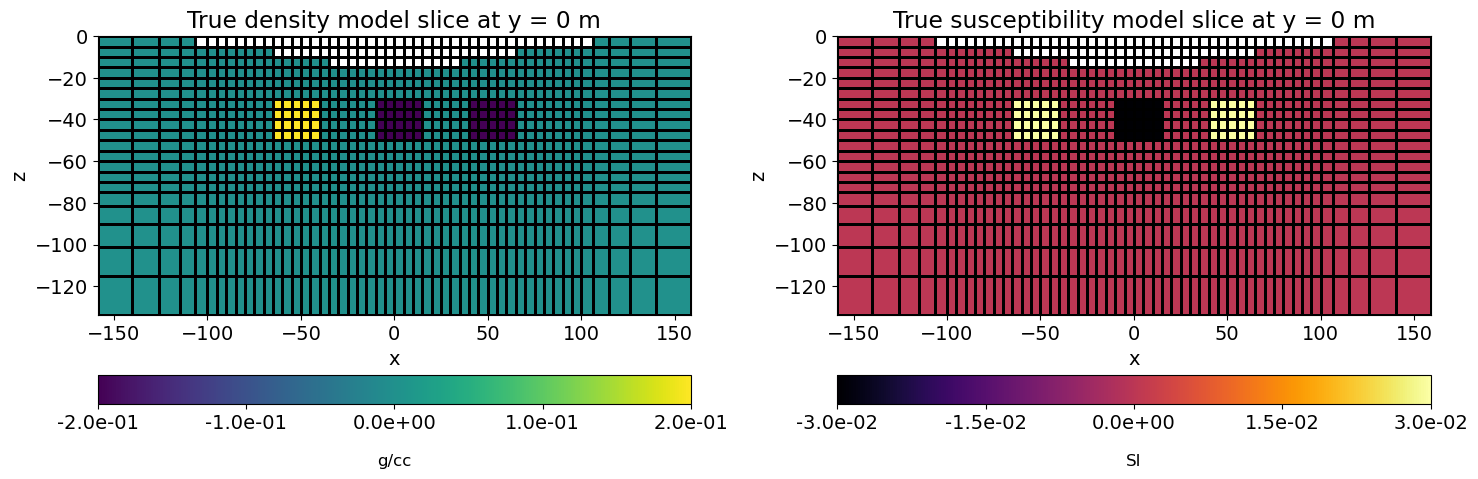

In [22]:
fig = plt.figure(figsize=(15, 5))
ax1 = plt.subplot(121)

(im,) = mesh.plot_slice(true_model_dens, normal="Y", ax=ax1, grid=True)
ax1.set_title("True density model slice at y = 0 m")
ticks = np.linspace(np.nanmin(true_model_dens), np.nanmax(true_model_dens), 5)
cbar = plt.colorbar(im, ticks=ticks, orientation="horizontal", format="%.1e")
cbar.set_label("g/cc", rotation=0, labelpad=15, size=12)

ax2 = plt.subplot(122)
(im,) = mesh.plot_slice(
    true_model_susc, normal="Y", ax=ax2, grid=True, pcolor_opts={"cmap": "inferno"}
)
ax2.set_title("True susceptibility model slice at y = 0 m")
ticks = np.linspace(np.nanmin(true_model_susc), np.nanmax(true_model_susc), 5)
cbar = plt.colorbar(im, ticks=ticks, orientation="horizontal", format="%.1e")
cbar.set_label("SI", rotation=0, labelpad=15, size=12)
plt.tight_layout()
plt.show()

## Plotting Independent Inversion Results

Here, we load and plot the density and magnetic susceptibility models that would have been recovered from independent inversion.

In [23]:
m_dens_single = np.loadtxt(dir_path + "single_model_dens.txt")
m_susc_single = np.loadtxt(dir_path + "single_model_susc.txt")

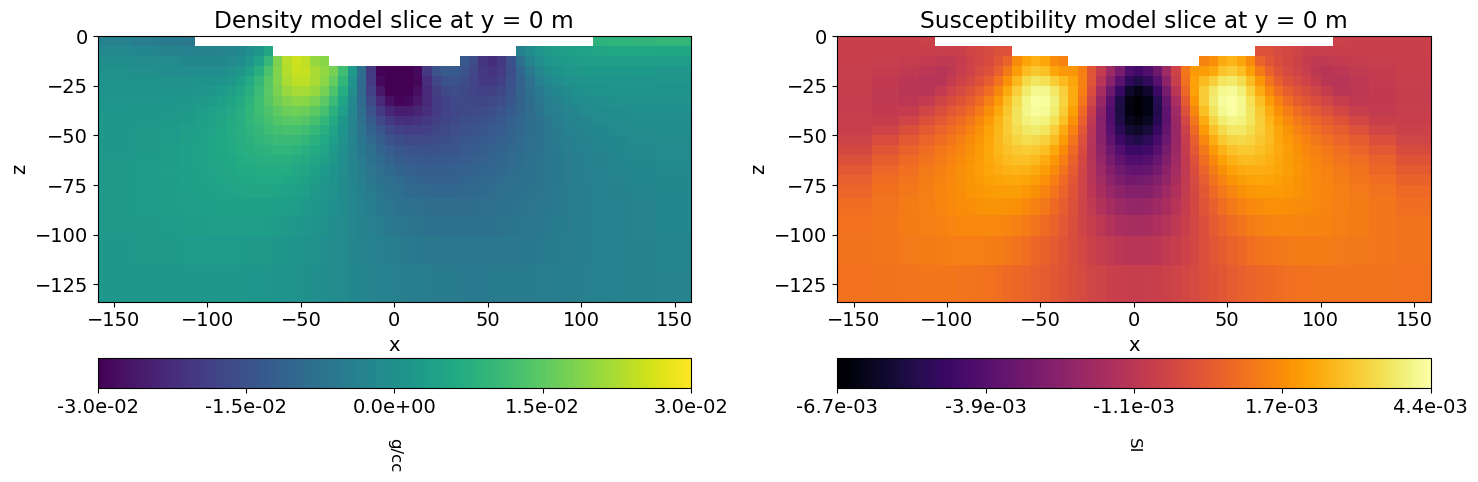

In [24]:
fig = plt.figure(figsize=(15, 5))

ax1 = plt.subplot(121)
(im,) = mesh.plot_slice(
    m_dens_single,
    normal="Y",
    ax=ax1,
    clim=(-0.03, 0.03),
)
ax1.set_title("Density model slice at y = 0 m")
ticks = np.linspace(-0.03, 0.03, 5)
cbar = plt.colorbar(im, ticks=ticks, orientation="horizontal", format="%.1e")
cbar.set_label("g/cc", rotation=270, labelpad=15, size=12)

ax2 = plt.subplot(122)
(im,) = mesh.plot_slice(
    m_susc_single, normal="Y", ax=ax2, pcolor_opts={"cmap": "inferno"}
)
ax2.set_title("Susceptibility model slice at y = 0 m")
ticks = np.linspace(np.nanmin(m_susc_single), np.nanmax(m_susc_single), 5)
cbar = plt.colorbar(im, ticks=ticks, orientation="horizontal", format="%.1e")
cbar.set_label("SI", rotation=270, labelpad=15, size=12)

plt.tight_layout()
plt.show()

## Plotting Recovered Models Using Cross-Gradient

Here, we plot the density and magnetic susceptibility models recovered using joint inversion with cross-gradient.

In [25]:
m_dens_joint, m_susc_joint = wires * recovered_model
plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)

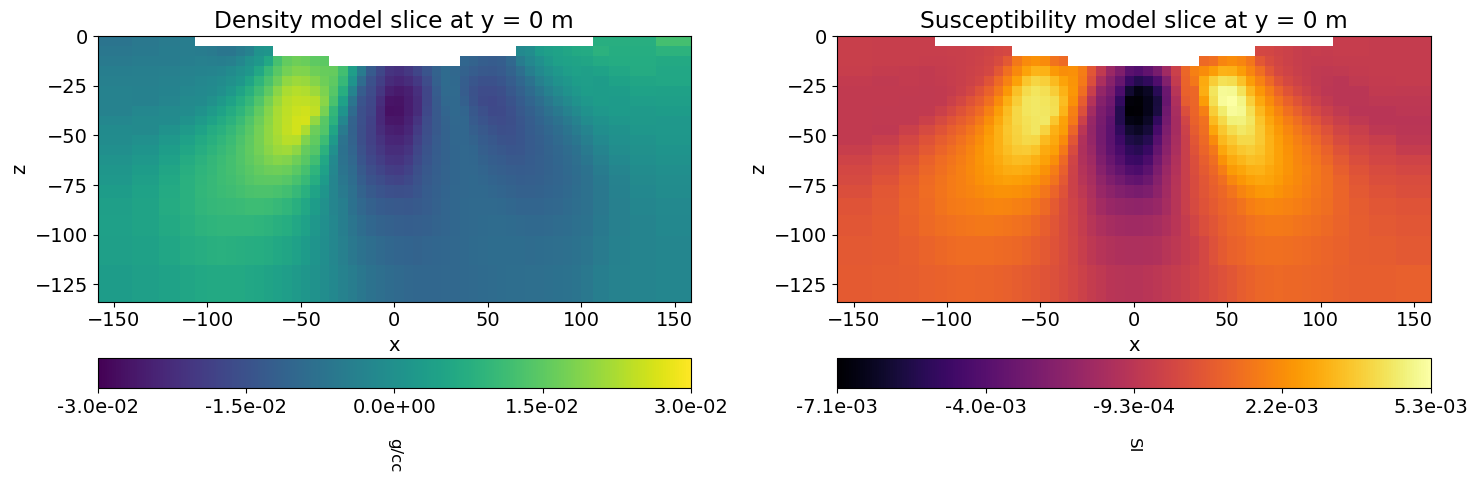

In [26]:
fig = plt.figure(figsize=(15, 5))

ax1 = plt.subplot(121)
(im,) = mesh.plot_slice(
    plotting_map * m_dens_joint,
    normal="Y",
    ax=ax1,
    clim=(-0.03, 0.03),
)
ax1.set_title("Density model slice at y = 0 m")
ticks = np.linspace(-0.03, 0.03, 5)
cbar = plt.colorbar(im, ticks=ticks, orientation="horizontal", format="%.1e")
cbar.set_label("g/cc", rotation=270, labelpad=15, size=12)

ax2 = plt.subplot(122)
(im,) = mesh.plot_slice(
    plotting_map * m_susc_joint, normal="Y", ax=ax2, pcolor_opts={"cmap": "inferno"}
)
ax2.set_title("Susceptibility model slice at y = 0 m")
ticks = np.linspace(np.nanmin(m_susc_joint), np.nanmax(m_susc_joint), 5)
cbar = plt.colorbar(im, ticks=ticks, orientation="horizontal", format="%.1e")
cbar.set_label("SI", rotation=270, labelpad=15, size=12)

plt.tight_layout()
plt.show()

## Comparing Jointly and Independently Recovered Models

Here, we use a cross-plot to illustrate how cross-gradient increases the
correlation between density and magnetic susceptibility values in
the recovered model.

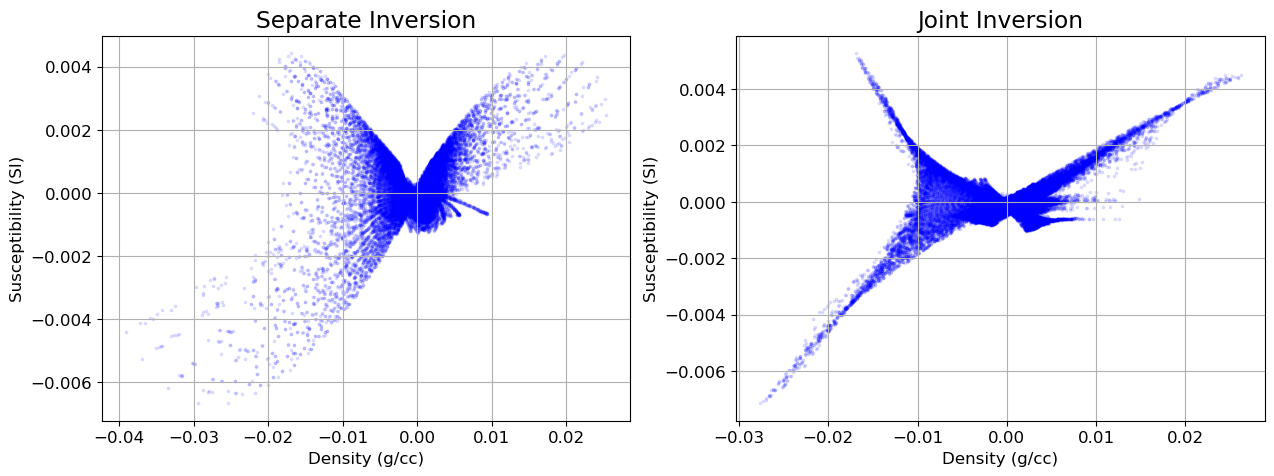

In [27]:
fig = plt.figure(figsize=(15, 5))

ax1 = plt.subplot(121)
ax1.scatter(m_dens_single, m_susc_single, s=3, c="blue", alpha=0.1)
ax1.grid(which="both")
ax1.set_xlabel("Density (g/cc)", size=12)
ax1.set_ylabel("Susceptibility (SI)", size=12)
ax1.tick_params(labelsize=12)
ax1.set_title("Separate Inversion")

ax2 = plt.subplot(122)
ax2.scatter(
    plotting_map * m_dens_joint, plotting_map * m_susc_joint, s=3, c="blue", alpha=0.1
)
ax2.grid(which="both")
ax2.set_xlabel("Density (g/cc)", size=12)
ax2.set_ylabel("Susceptibility (SI)", size=12)
ax2.tick_params(labelsize=12)
ax2.set_title("Joint Inversion")

plt.show()